# 20新卒データベース研修: チュートリアル

Google Colaboratory（通称Colab）を利用すると Python のスクリプトを対話的に実行した結果をノートブックという形式でまとめることができます。ここではGoogleのBigQueryというサービスやSQLiteというアプリケーションに組み込み可能なリレーショナルデータベースを利用しSQLクエリなどの使い方を学んでいきます。

```
【注意】新型コロナウイルスに関係するオープンデータを取り扱っています
新型コロナウイルスについては、必ず1次情報として厚生労働省や首相官邸のウェブサイトなど公的機関で発表されている情報をご確認ください
```

### 目次

1. 設定
2. データの取得
3. データの操作
4. 集計処理
5. 集合操作
6. インデックス
7. 分析関数
8. データ活用

## 設定

### Google Cloud SDKの設定

最初にBigQueryを利用するための環境を構築していきます。まずはGoogleアカウントのOAuthトークンを取得しノートブック上でGoogle Cloud SDKを利用できるようにします。

OAuth認証の流れ

- 下記の"OAuth認証"スクリプトを実行する（Shift + Enter）
- 表示されるURLをブラウザで開きColaboratoryによるアクセスを許可
- 英数字と記号からなるトークン文字列をコピー
- URLの下に入力されている入力ボックスにトークン文字列をペーストしてEnter

まずは下の`OAuth認証`と書かれたスクリプトを実行してみましょう。



In [0]:
#
# OAuth認証
#
from google.colab import auth
auth.authenticate_user()

`!`（びっくりマーク）で始まる行はシェルコマンドとして取り扱われます。

gcloud コマンドを使って認証情報が設定できたか確認していきます。

In [0]:
# このセルの実行結果に自分のメールアドレスが表示されたら準備完了です
! gcloud auth list

Google Cloud SDKの設定を確認できたら安全のためブラウザのトークンが表示されているタブを閉じておきましょう。

### 研修用のGCPプロジェクトを作成する

GCPに限らずクラウドサービスでは無料枠が提供されていることがあります。クラウドサービスのコスト感を掴むには実際に触ってみるのが手っ取り早いです。基本的にはクラウドサービス側の思惑で料金が決まっているので触ってみると思っているより安かったり高かったりすることがあります。

今回はBigQuery（Sandbox）を利用するために研修用のGCPプロジェクトを作成してみましょう。

In [0]:
import uuid
PROJECT_ID=f'db-training-2020-{str(uuid.uuid4())[:8]}'

PROJECT_ID

上のセルを実行して表示されたプロジェクトを今回の研修で利用します。

In [0]:
! gcloud projects create {PROJECT_ID}

下記のスクリプトで出力されるURLを開くとBigQueryのWebコンソール画面に入ることができます。

In [0]:
print(f'http://console.cloud.google.com/bigquery?project={PROJECT_ID}')

### BigQueryを使ってみる

ここで `%%` で始まる行はセルマジックと呼ばれる機能でセルに対して拡張機能で操作を行うときに使用します。ここでは BigQuery との連携機能を使用しており `%%bigquery` という文字列の下にあるSQLクエリを BigQuery 上で実行することができます。

`--project`はBigQueryを利用するGCPプロジェクト名の指定です。`{PROJECT_ID}`のように波括弧で囲まれた文字列はPythonの式として評価され先ほど作成したプロジェクトを指定しています。

In [0]:
%%bigquery --project {PROJECT_ID}
select 'Hello' as World

上記のSQLを実行し下の画像のような結果が表示されたら設定完了です 👌

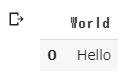

### Colab TIPS: コーギーを表示するには 🐶

[ツール] => [設定] => [その他] で [コーギーモードを有効化] するとコーギーが走ります。

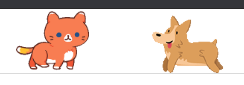

## データの取得

BigQueryでは学習用に公開データセットが提供されています。まずはどんなデータがあるかの調査を通してSELECT文の使い方を学んでみましょう。

BigQueryではINFORMATION_SCHEMAというテーブル情報を取得するためのメタデータが提供されており、これを利用することでテーブル情報を取得することができます。MySQLやPostgreSQLなどのRDBMSでも同様のスキーマ情報が提供されており、これを利用することでテーブル管理が容易になることがあります。

### SELECT 文: 基本形

SQLクエリを使ってデータを取得する時はSELECT文を利用します。

```sql
    SELECT
        <式>
    FROM
        <テーブル名>
    WHERE
        <検索条件>
```

下記のクエリではJohns Hopkins大学が提供する新型コロナウイルス（COVID-19）に関する公開データセットに関する情報を取得します。

- Project ID: `bigquery-public-data`
- Dataset Name: `covid19_jhu_csse`
- Schema Name: `INFORMATION_SCHEMA`
- テーブル名: `TABLES`

In [0]:
%%bigquery --project {PROJECT_ID}
-- これはコメントです
select
  -- 全てのカラムを取ってくる
  *
from
  bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES

テーブル名や作成時刻が確認できました。

### LIMIT 句

LIMIT句を利用することで取得するレコード数を制限することができます。大量データを取得するとデータベースのクライアントが捌ききれずトラブルに繋がる場合があるので、SELECT文を使ってデータを見るときはLIMIT句でデータ量を制限するようにしておくことをお勧めします。

ここではLIMIT句を使って confirmed_cases というテーブルに含まれるレコードを3件表示してみましょう。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
limit 3

### 検索

WHERE句に検索条件を指定すると取得対象のレコードを絞り込むことができます。

先ほどのクエリの結果をみると `country_region` というカラムが国名を表しているようですのでWHERE句を使って試しに日本（JAPAN）のレコードを取得してみましょう。



In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_region = 'JAPAN'

はい、表示されませんでした。どうやら日本を表す `country_region` は `JAPAN` ではないようです。LIKE 演算子を利用すると文字列のパターンマッチングが出来るのでこれを使って `J` で始まる country_region を検索してみましょう。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  country_region
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_region LIKE 'J%'

`Japan` は見つかったでしょうか。先ほどのクエリのWHERE句を Japan に修正して再度実行してみます。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_region = 'Japan'

日本の感染者数に関するデータが取得できました。国名を表すカラムのほかには位置情報に関する情報も入っており、`_1_22_20` などのカラムは `MM/DD/YY` 形式である日付における感染者数を表しているようです。

## データの操作

ここからBigQueryに代わってSQLiteを使ってテーブルにレコードを追加・更新・削除する方法について確認していきます。

> CRUD（クラッド）とは、ほとんど全てのコンピュータソフトウェアが持つ永続性[1]の4つの基本機能のイニシャルを並べた用語。その4つとは、Create（生成）、Read（読み取り）、Update（更新）、Delete（削除）である。ユーザインタフェースが備えるべき機能（情報の参照/検索/更新）を指す用語としても使われる。
>
> https://ja.wikipedia.org/wiki/CRUD

### Colab: SQLマジックの有効化

ColaboratoryではJupyter Notebook用の拡張機能を利用することができます。ここではSQLiteに対してクエリを発行できるようにするため `ipython-sql` という拡張機能をインストールします。

In [0]:
! pip install ipython-sql

### SQLite: データベースの作成


インストールした拡張機能は `%load_ext` というコマンドで読み込むことができます。`ipython-sql` は SQL マジックと呼ばれる機能を提供しており、`%%sql` で始まるセルを SQL クエリとして取り扱うことができます。

In [0]:
# ipython-sqlの読み込み
%load_ext sql

# SQLite3への接続
%sql sqlite:///tmp.sqlite3

### テーブルの作成

SQLite3ではCREATE TABLE文を実行することでテーブルを作成することができます。

```sql
    CREATE TABLE <テーブル名> (
      -- カラム情報
      <カラム名> <データ型>,
      ...
    )
```

In [0]:
%%sql
create table messages (
    id bigint,
    message string
)

In [0]:
%%sql
select count(1) from messages

`CREATE TEMPORARY TABLE`文を利用すると一時的なテーブルを作成することができます。クライアントのセッションが切れると削除されるテーブルでバッチ処理などではテーブル作成時などに一時的な集計結果を格納したりするときによく利用する機能です。

In [0]:
%%sql
create temporary table tmp_messages (
    id bigint,
    message string
)

一時テーブルも同様にクエリを実行することが可能です。

In [0]:
%%sql
select * from tmp_messages

### レコードの追加

テーブルを作成できたらテーブルにレコードを入れてみましょう。INSERT文を利用するとテーブルにデータを格納することができます。

```sql
    INSERT INTO
        <テーブル名>
    VALUES
        (v1, v2, ...),
        ...
```

In [0]:
%%sql
insert into
  messages
values
  (1, 'こんにちは'),
  (2, '夜だけどこんにちは')

In [0]:
%%sql
select
  *
from
  messages

### レコードの更新

続けて、UPDATE文を利用することで検索条件にマッチするレコードを更新することができます。

In [0]:
%%sql
-- idが1のレコードのメッセージを更新する
update
  messages
set
  message = 'こんにちはこんにちは'
where
  id = 1

In [0]:
%%sql
select
  *
from
  messages

### レコードの削除

主にコストの面でストレージには限りがある場合があるので不要なレコードは削除しましょう。DELETE文を利用すると検索条件にマッチするレコードを削除することができます。

In [0]:
%%sql
delete from
  messages
where
  id = 1

In [0]:
%%sql
select
  *
from
  messages

検索条件を指定しない場合は全てのレコードが削除されます。

In [0]:
%%sql
delete from messages

MySQLなどのRDBMSにはTRUNCATE文という全レコードを削除するためのコマンドが用意されています。

それぞれ以下のような特徴があります

- DELETE文
    - トランザクションでロールバックできる
- TRUNCATE文
    - テーブルを再構築するためロールバックできないが高速

### テーブルの削除

DROP TABLE文を利用することでテーブルを削除することができます。

In [0]:
%%sql
drop table messages

## 集計

### COUNT関数

プロジェクトの選択を求められた場合は最初に作成したプロジェクト名を選択するか停止して再実行してみてください。

In [0]:
! bq mk --project_id {PROJECT_ID} {PROJECT_ID}:tmp

多くのクエリエンジンにはテーブルを作成する際に SELECT 文の実行結果をそのまま利用できる `CREATE TABLE AS`（CTAS） と呼ばれる構文が用意されています。

一時テーブルと組み合わせて集計に時間がかかるようなクエリの実行結果を保存しておいたり、異なるデータベースサーバーに入っているテーブルデータをコピーするときなどに便利な機能です。

以下ではBigQueryの公開データセットからデータを取得し `tmp` スキーマの `confirmed_casess` というテーブルにデータを格納します。

In [0]:
%%bigquery --project {PROJECT_ID}
create table tmp.confirmed_cases as
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases

COUNT関数を利用するとレコード数を数えることができます。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  count(1) as num
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases

先ほど作成したテーブルのレコード数を数えてみましょう。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  count(1) as num
from
  tmp.confirmed_cases

### Pandasによるデータ整形（ピボット操作）

#### BigQuery => Pandas

公開データセットには国ごとに感染者数が各カラムに入っていますが、一つ一つカラムを指定するのは大変なので

↓これを

```
|国名|日付1|日付2|...|
|A  |123|456|...|
|B  |789|999|...|
```

↓こうしたい

```
|日付|国A|国B|
|日付1|123|789|
|日付2|456|999|
```

このような操作を一般的にテーブルのピボットと呼びますが、BigQueryにはピボットの機能は入っておりません。

集約操作を駆使することで表現することは可能ですがSQLで全てを記述するよりプログラミング言語を使った方が簡潔です。ここでは Pandas という Python のデータ操作用フレームワークを利用してテーブルを回転させてみましょう。

"pandas - Python Data Analysis Library"
https://pandas.pydata.org/

BigQueryマジックでは `%%bigquery` の引数に変数名を指定すると、クエリの実行結果を Pandas の DataFrame というデータ構造に変換して格納してくれます。

In [0]:
%%bigquery --project {PROJECT_ID} df_confirmed_cases
-- クエリの実行結果をPandasのデータフレームに入れる
select
  *
from
  tmp.confirmed_cases
where
  -- 州を持たない国のレコードを抽出してみる
  province_state is null

headメソッドを使って上位のレコードを表示してみます。

In [0]:
df_confirmed_cases.head()

SELECT文のWHERE句のように条件指定することも可能です。独特の記法ですが配列の添字アクセスのところで条件指定をすると条件に一致するレコードを抽出することができます。

```py
    df[条件式]
```

In [0]:
df_confirmed_cases[df_confirmed_cases.country_region == 'Japan']

ilocという機能を使うと行や列の絞り込みができます。SQLよりも列方向の操作がしやすくなるのが利点です。

以下では日本の感染者数を抽出しています。

In [0]:
df_confirmed_cases[df_confirmed_cases.country_region == 'Japan'].iloc[:, 5:]

Pandas DataFrameにはtransposeという行列の行と列を入れ替える転置機能が用意されており T 属性で呼び出すことができます。ここでは日本の感染者数を縦持ちのデータに変換しています。

In [0]:
df_confirmed_cases[df_confirmed_cases.country_region == 'Japan'].iloc[:, 5:].T

一般的にクエリエンジンでのデータのスキャンは縦方向に進むので横向きよりも縦向きのデータの方が取り扱いやすいことが多いです。特にR言語というデータ分析向けのプログラミング言語の界隈では分析に使いやすいデータのことを `整然データ（tidy data）` と読んでおりデータを扱いやすくするための方法について議論されています。

"【翻訳】整然データ｜Colorless Green Ideas"
http://id.fnshr.info/2017/01/09/trans-tidy-data/

縦向きにしたことでPandasでのデータの可視化ができるようになります。

In [0]:
df_confirmed_cases[df_confirmed_cases.country_region == 'Japan'].iloc[:, 5:].T.plot.line()

#### Pandas => BigQuery

Japan、Albania、Panamaの3カ国について同様に縦持ちのテーブルを作ってみましょう。

In [0]:
import pandas as pd

target_regions = ['Japan', 'Albania', 'Panama']
df_selected = df_confirmed_cases[df_confirmed_cases.country_region.isin(target_regions)]
df_confirmed_cases_t = pd.DataFrame(df_selected.iloc[:, 5:].T.values, columns=target_regions)
df_confirmed_cases_t

Pandas DataFrameの `to_gbq` メソッドを使うことでデータフレームをBigQueryのテーブルに格納することができます。

In [0]:
df_confirmed_cases_t.to_gbq('tmp.confirmed_cases_t', PROJECT_ID, if_exists='replace')

Pandasで整形したデータをBigQueryで取り扱えるようになりました。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  tmp.confirmed_cases_t

作成したテーブルを再度BigQueryに持っていき国ごとの推移をみてみましょう

In [0]:
%%bigquery --project {PROJECT_ID} df_confirmed_cases_t
select
  *
from
  tmp.confirmed_cases_t

In [0]:
df_confirmed_cases_t.plot.line()

seabornというライブラリを利用するとグラフの見た目を整えることができます。

In [0]:
! pip install seaborn

In [0]:
import seaborn as sns
sns.set()

In [0]:
df_confirmed_cases_t.plot.line()

指数的に増加してるグラフの増加具合を比較するときは縦軸を対数で取ると見やすくなります。元のグラフと違って収束していく形になるので取り扱いには注意が必要です。

In [0]:
%%bigquery --project {PROJECT_ID} df_confirmed_cases_t_log
select
  log(Japan+1, 10) as Japan_log10,
  log(Albania+1, 10) as  Albania_log10,
  log(Panama+1, 10) as Panama_log10
from
  tmp.confirmed_cases_t

In [0]:
df_confirmed_cases_t_log.plot.line()

余裕があれば以下に取り組んでみてください。

- 対数グラフの開始日を揃えてみる
- 他の国についても調べてみる

### 集約操作（GROUP BY）

データセットを見ていると国によっては複数のレコードを持っていることが分かります。GROUP BY 句を利用すると指定したカラムの値でグループ分けした結果に対して COUNT 関数などを利用した集計を行うことができます。

```sql
    SELECT
      <カラム>
    FROM
      <テーブル>
    WHERE
      <条件>
    
    -- NEW!!
    GROUP BY
      <集約するカラム> -- 複数指定可能
    HAVING
      集約後の結果に対する条件指定
```

以下は州がNULLではない国について country_region ごとにレコード数を集計したものです

In [0]:
%%bigquery --project {PROJECT_ID}
select
  country_region,
  count(1) as records
from
  tmp.confirmed_cases
where
  province_state is not null

group by
  country_region

having
  records > 1

> 連邦国家であるカナダを構成する10の州（プロヴィンス、province）と3つの準州（テリトリー、territory）
>
> "カナダの州 - Wikipedia" https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%8A%E3%83%80%E3%81%AE%E5%B7%9E

15個あるのはダイヤモンドプリンセス号などが含まれるようでした。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  country_region,
  count(1) as provinces
from
  tmp.confirmed_cases
where
  country_region = 'Canada'

group by
  country_region

#### BigQuery => Pandas

複数の州を持つ国の感染者数を日別にまとめてみましょう。BigQueryの特徴的な機能としてSELECT文の全カラム指定から除外するカラムを指定することができデータの抽出が容易になります。

以下では地理データに関するカラムを除外しています。

In [0]:
%%bigquery --project {PROJECT_ID} df_provinces
select
  * except (latitude, longitude, location_geom)
from
  tmp.confirmed_cases
where
  province_state is not null

Pandasを使って国・州・日付ごとに感染者数を縦持ちにしたテーブルを作成します。

"pandasでstack, unstack, pivotを使ってデータを整形 | note.nkmk.me"
https://note.nkmk.me/python-pandas-stack-unstack-pivot/

In [0]:
import pandas as pd

df_pivot_stack = pd.pivot_table(df_provinces, index=['country_region', 'province_state']).stack().reset_index()
df_pivot_stack.columns = ['country_region', 'province_state', 'date', 'confirmed_cases']
df_pivot_stack

そのままだと日付が文字列としてソートされてしまいグラフにするときに影響が出てしまいます

ここでは大小比較を正しく行うためにPythonのdatetime型に変換しています

In [0]:
import datetime
datetime.datetime.strptime('_1_22_20', '_%m_%d_%y')

# 日付順で並べ替えるため日付文字列をdatetime型に変換
df_pivot_stack.date = df_pivot_stack.date.map(lambda d: datetime.datetime.strptime(d, '_%m_%d_%y'))
df_pivot_stack

Pandas => BigQuery

In [0]:
df_pivot_stack.to_gbq('tmp.pivot_stack', PROJECT_ID, if_exists='replace')

複数州を持つ国についても日別の推移を縦持ちで取れるようになりました。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  tmp.pivot_stack

ここから GROUP BY 句を使って国・日別でconfirmed_casesの和を取ってみます。

総和の集計には SUM 関数を利用しています。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  country_region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  country_region,
  date

order by
  country_region,
  date

3カ国でやったように線グラフにしてみましょう。例によって縦軸を対数で取ってあるのに注意してください。

In [0]:
%%bigquery --project {PROJECT_ID} df_confirmed_cases_sum
select
  country_region,
  date,
  log(sum(confirmed_cases)+1, 10) as confirmed_cases_sum_log10
from
  tmp.pivot_stack
group by
  country_region,
  date
order by
  country_region,
  date

In [0]:
pd.pivot_table(df_confirmed_cases_sum, index=['date'], columns=['country_region']).plot.line(y='confirmed_cases_sum_log10')

オーストラリアやカナダのconfirmed_casesの推移が見えるようになったでしょうか。

## 集合操作

ここから少し複雑なSELECT文を扱っていきます。

### サブクエリ

サブクエリはクエリの中に記述されたSELECT文のことです。データを集合的に操作するときに重宝します。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  (select
    *
  from
    bigquery-public-data.covid19_jhu_csse.confirmed_cases
  )
where
  -- サブクエリの結果に対して条件指定
  country_region = 'Japan'

### WITH句
WITH 句を利用するとサブクエリに名前を付けて外側に持っていくことでネストを下げることができます。WITH 句で定義したサブクエリは通常のテーブルと同様にクエリすることができます。

RDBMSの世界ですとMySQLは長らくサポートしていませんでしたがバージョン8.0から利用できるようになっています。

In [0]:
%%bigquery --project {PROJECT_ID}
with
  japan_confirmed_cases as
  (select
    *
  from
    bigquery-public-data.covid19_jhu_csse.confirmed_cases
  where
    country_region = 'Japan'
  )

select
  *
from
  japan_confirmed_cases

### UNION

UNION 句を利用するとクエリの結果を縦方向に結合することができます。

ここでは confirmed_cases / recovered_cases / deaths の3テーブルの結果を UNION 句で結合し、それぞれの推移をグラフで見てみましょう。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES

label というカラムに元テーブルの名前を格納することで区別できるようにしています。UNION だけだとそれぞれのセットで重複するものが排除されますがその分パフォーマンスが落ちてしまいます。UNION ALL と指定すると重複チェックを行わずに結果を結合することができます。

In [0]:
%%bigquery --project {PROJECT_ID} df_jp
with
  confirmed_cases as
  (select
    'confirmed' as label,
    * except (latitude, longitude, location_geom)
  from
    bigquery-public-data.covid19_jhu_csse.confirmed_cases
  where
    country_region = 'Japan'
  ),
  
  recovered_cases as
  (select
    'recovered' as label,
    * except (latitude, longitude, location_geom)
  from
    bigquery-public-data.covid19_jhu_csse.recovered_cases
  where
    country_region = 'Japan'
  ),
  
  deaths as
  (select
    'death' as label,
    * except (latitude, longitude, location_geom)
  from
    bigquery-public-data.covid19_jhu_csse.deaths
  where
    country_region = 'Japan'
  )

select
  *
from
  confirmed_cases

union all
select
  *
from
  recovered_cases

union all
select
  *
from
  deaths

In [0]:
df_jp.head()

In [0]:
df_jp_t = df_jp.pivot_table(index='label').T
df_jp_t

In [0]:
df_jp_t.index = df_jp_t.index.map(lambda d: datetime.datetime.strptime(d, '_%m_%d_%y'))
df_jp_t.plot.line()

### JOIN

JOINを利用することで複数のテーブルまたはサブクエリを特定の条件で横方向に結合することができます。

結合方式には以下の3種類があり、それぞれ役割が異なります。

- 内部結合（INNER JOIN）
  - 一致するもの
- 外部結合（OUTER JOIN）
  - 一致しないときはNULL
- クロス結合（CROSS JOIN）
  - 直積
  - 配列データをバラしたりするときに便利

```sql
    SELECT
      <式>
    FROM
      <テーブル>
    
    -- NEW!!
    JOIN
      <結合するテーブル>
    ON
      <結合条件>
```

ここでは SQLite を使って JOIN の使い方を学んでみます。

In [0]:
%%sql
-- ユーザー情報
create table users (
    id bigint,
    user_name string
);

-- ステージ情報
create table stages (
    id bigint,
    stage_name string
);

-- プレイログ
create table plays (
    id bigint,
    user_id bigint,
    stage_id bigint
)

レコードの追加

In [0]:
%%sql
insert into
  users
values
  (1, 'Alice'),
  (2, 'Bob')
;

insert into
  stages
values
  (1, 'Easy Stage'),
  (2, 'Normal Stage')
;

ログデータの追加

In [0]:
%%sql
insert into
  plays
values
  (1, 1, 1),
  (2, 1, 2),
  (3, 2, 1),
  (4, 1, 1)
;

そのままだと誰がどのステージをプレイしたのか分からないのでユーザー名とステージ名をJOINしてみます。

In [0]:
%%sql
select
  *
from
  plays as p

In [0]:
%%sql
select
  p.id,
  u.user_name,
  s.stage_name
from
  plays as p

join
  users as u
on p.user_id = u.id

join
  stages as s
on p.stage_id = s.id

### CROSS JOIN

CROSS JOINはテーブルをバラすときに便利です。と言っても具体例をみないと分かりづらいのでSQLiteのJSON型を使ってCROSS JOINの使いどころを確認してみましょう。

In [0]:
%%sql
-- JSON型を持ったテーブルを作成
create table json_messages (
    id bigint,
    msg json
)

JSON型のカラムには文字列としてINSERTすることができます

In [0]:
%%sql
insert into
  json_messages
values
  (1, '{"hello": "JSON"}')

In [0]:
%%sql
select * from json_messages

JSON関数も用意されておりパースに失敗するとエラーを返してくれます

In [0]:
%%sql
insert into
  json_messages
values
  (3, json('{"users": [1, 2]}'))

JSON_EXTRACT関数を使うとJSONから指定のキーを持つ値を抽出できます。

In [0]:
%%sql
select
  json_extract(msg, '$.users') as users
from
  json_messages
where
  id = 3

配列を1行ずつバラしていくときにCROSS JOINが活用できます。

In [0]:
%%sql
select
  value as user
from
  (select
    json_extract(msg, '$.users') as users
  from
    json_messages
  where
    id = 3
  ) as t
cross join
  json_each(t.users)

## インデックス

RDBMSではデータを高速に取得するためにインデックスと呼ばれる機能を利用できます。

### テーブル結合

例のためUUIDというランダムな文字列を100万件取得します

In [0]:
%%bigquery --project {PROJECT_ID} df_seq1
select
  x,
  generate_uuid() as uuid1
from
  unnest(generate_array(1, 1000000)) as x
order by
  rand()

In [0]:
df_seq1.head()

In [0]:
%%bigquery --project {PROJECT_ID} df_seq2
select
  x,
  generate_uuid() as uuid2
from
  unnest(generate_array(1, 1000000)) as x
order by
  rand()

取得したUUIDをSQLiteに格納していきます

In [0]:
import sqlite3
df_seq1.to_sql('seq1', sqlite3.connect('tmp.sqlite3'), if_exists='replace')
df_seq2.to_sql('seq2', sqlite3.connect('tmp.sqlite3'), if_exists='replace')
df_seq1.to_sql('seq1_ind', sqlite3.connect('tmp.sqlite3'), if_exists='replace')
df_seq2.to_sql('seq2_ind', sqlite3.connect('tmp.sqlite3'), if_exists='replace')

件数を確認してみましょう

In [0]:
%%sql
select count(1) from seq1
union all
select count(1) from seq2

`%%time` マジックを利用するとセルの実行に掛かる時間を計測することができます

まずはインデックスを未使用のテーブル（seq1, seq2）について同じキーを持つレコードをJOINしてみましょう

In [0]:
%%time
%%sql
select
  count(1),
  count(distinct x),
  sum(x)
from
  seq1
join
  seq2
using (x)

order by
  x

SQLiteではCREATE INDEX文を利用することでインデックスを設定することができます。

インデックス未設定のテーブルと区別するため先ほどのテーブル名に _ind という接尾辞を付けてあります。

In [0]:
%%sql
create index seq1_x on seq1_ind(x);
create index seq2_x on seq2_ind(x);

先ほどのJOINクエリをインデックス設定したテーブルを使って実行してみます。

In [0]:
%%time
%%sql
select
  count(1),
  count(distinct x),
  sum(x)
from
  seq1_ind -- index x
join
  seq2_ind -- index x
using (x)

order by
  x

速くなったでしょうか。単一のクエリだと分かりにくいですね (´ω｀)

### EXPLAIN文

クエリエンジンにはEXPLAIN文というクエリの実行計画を確認できる機能があり、クエリを実行したときにどういったAPIが実行されるか事前に確認することができます。

SQLiteにもEXPLAINが用意されているので、先ほどのクエリで呼び出される機能をEXPLAINで確認してみましょう

In [0]:
%%sql
explain
select
  count(1),
  count(distinct x)
from
  seq1
join
  seq2
using (x)

order by
  x

In [0]:
%%sql
explain
select
  count(1),
  count(distinct x)
from
  seq1_ind
join
  seq2_ind
using (x)

order by
  x

### 複数のクエリ

インデックスが効果を発揮するのはクエリが複数回実行されるケースになります。ここでは複数回クエリが実行された時のインデックスの効果を体感してみましょう。

実行時間の進捗を確認するために tqdm というライブラリを使用します。

In [0]:
! pip install tqdm

以下のスクリプトは seq1 テーブルからカラム x が指定の値になっているレコードを抽出するクエリを300回呼び出したものです。

まずはインデックス未使用の場合で実行してみましょう。

In [0]:
%%time
import pandas as pd
import sqlite3
import tqdm

def generate_sql(x):
  return f'''
    select
      uuid1
    from
      seq1
    where
      x = {x}
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(1, 300)):
    pd.read_sql(generate_sql(x), con=con)

'done'

続けてインデックスを使用した場合を試してみます。

In [0]:
%%time
import pandas as pd
import sqlite3
import tqdm

def generate_sql(x):
  return f'''
    select
      uuid1
    from
      seq1_ind -- index x
    where
      x = {x}
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(1, 300)):
    pd.read_sql(generate_sql(x), con=con)

'done'

一瞬で終わりました

次のクエリはどうなるでしょうか

In [0]:
%%time
import pandas as pd
import sqlite3
import tqdm

def generate_sql(x):
  return f'''
    select
      uuid1
    from
      seq1_ind -- index x
    where
      x = {x}
      or uuid1 like 'a%'
  '''

with sqlite3.connect('tmp.sqlite3') as con:
  for x in tqdm.tqdm(range(1, 300)):
    pd.read_sql(generate_sql(x), con=con)

'done'

OR演算子でインデックスを使っていない条件式が含まれるのでインデックスが使われないようです。ミスは起こりうるものですが意図した通りにインデックスが使われているか確認する必要があります

## 分析関数（Window Functions）

次はBigQueryの世界に戻ってきます。分析関数はデータの集計だけではなく機械学習用のデータセットを作成するのにも便利に使える機能です。ウィンドウ関数を利用すると今みているレコードだけじゃなく他のレコードの状態をみて集計処理を実行できます。

### LEAD / LAG 関数

あるレコードについて指定の順序で前後にあるレコードのカラムを取得するための機能です。例えば日別のログイン履歴などでログインした日付と次にログインした日付を求めることでログインしなかった日数などを集計することができます。

In [0]:
%%bigquery --project {PROJECT_ID}
-- カナダのconfirmed_cases推移（日別）
select
  *
from
  tmp.pivot_stack
where
  country_region = 'Canada'
  and province_state = 'British Columbia'

order by
  date

LAG関数を使って前日のconfirmed_casesを取得してみます。ウィンドウ関数の利用時には `GROUP BY` による集約は必要なく、関数の後ろに `OVER` で始まる順序などの条件指定が入ります。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  date,
  confirmed_cases,
  lag(confirmed_cases) over (order by date) prev_confirmed_cases
from
  tmp.pivot_stack
where
  country_region = 'Canada'
  and province_state = 'British Columbia'

order by
  date

元のデータセットはconfirmed_casesが累計値になっています。前日との差分を取ることで1日あたりどれくらい増加したのか集計してみます。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  date,
  confirmed_cases,
  confirmed_cases - prev_confirmed_cases as confirmed_cases_diff
from
  (select
    date,
    confirmed_cases,
    lag(confirmed_cases) over (order by date) prev_confirmed_cases
  from
    tmp.pivot_stack
  where
    country_region = 'Canada'
    and province_state = 'British Columbia'
  )

order by
  date

例によってPandasに格納してプロットしてみます

In [0]:
%%bigquery --project {PROJECT_ID} df_canada
select
  date,
  confirmed_cases - prev_confirmed_cases as confirmed_cases_diff
from
  (select
    date,
    confirmed_cases,
    lag(confirmed_cases) over (order by date) prev_confirmed_cases
  from
    tmp.pivot_stack
  where
    country_region = 'Canada'
    and province_state = 'British Columbia'
  )

order by
  date

In [0]:
df_canada.plot.line(x='date', y='confirmed_cases_diff')

### 累積和

先ほどは累計値を日別に変換しましたが、逆に累計値を求めるにはどうすればよいでしょうか。SUM関数やCOUNT関数などもウィンドウ関数として利用することができ、あるレコードまでの累積和などを求めることができます。

In [0]:
%%bigquery --project {PROJECT_ID}
with
  df_canada as
  (select
    date,
    confirmed_cases as confirmed_cases_original,
    confirmed_cases - prev_confirmed_cases as confirmed_cases_diff
  from
    (select
      date,
      confirmed_cases,
      lag(confirmed_cases) over (order by date) prev_confirmed_cases
    from
      tmp.pivot_stack
    where
      country_region = 'Canada'
      and province_state = 'British Columbia'
    )
  )

select
  date,
  confirmed_cases_original,
  sum(confirmed_cases_diff) over (order by date) as confirmed_cases_cumsum
from
  df_canada

order by
  date

### RANK / ROW_NUMBER 関数

RANK / ROW_NUMBER 関数を使うとランキングを求めたり行番号を求めることができます。

使い分けは RANK は同一の値を持つときに同じランクになる場合があるのと、ROW_NUMBERは同一の値が出てきたときは最初に見つかった順に番号が振られます。

ROW_NUMBER関数についてはクエリの重複排除を行うときによく利用します（例: ROW_NUMBERの結果が1になるものだけ取ってくる）

ここではRANK関数を利用してconfirmed_casesが多い順にランク付けをしてみましょう。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  province_state,
  confirmed_cases,
  rank() over (order by confirmed_cases desc) as rank
from
  tmp.pivot_stack
where
  country_region = 'Canada'
  and date = '2020-03-31'

order by
  confirmed_cases

上位三件に絞り込んでみます。

In [0]:
%%bigquery --project {PROJECT_ID}
select
  *
from
  (select
    province_state,
    confirmed_cases,
    rank() over (order by confirmed_cases desc) as rank
  from
    tmp.pivot_stack
  where
    country_region = 'Canada'
    and date = '2020-03-31'
  )
where
  rank <= 3

order by
  rank

## データの活用

データベースに格納されているデータから今起こっている現象や未来の動きを説明する方法について学んでみましょう。

In [0]:
%%bigquery --project {PROJECT_ID} df
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.confirmed_cases` where country_region = "Japan" or country_region = 'US' order by country_region

USと日本の二つをとってくることにしてありますが、他の地域のデータで試してもいいと思います。

In [0]:
df.head()

### SIRモデル

以下で感染現象のモデルを定義します。今回用いるモデルは一般に”SIR”と呼ばれるタイプです。

感染現象は人と人の接触によって起きますが、これを完全に再現する理論がまだ無いので、もっと簡単に気体分子で代用します。つまり人を気体分子が表しており、分子同士の衝突が人と人との接触です。気体分子は他の分子を区別しないので、すべての分子が他の分子とぶつかる確率は等しくなります。これは直感的におかしい仮定ですが、案外これでも正確に計算できることが経験的に知られているのです。

このモデルの構成要素である人が持っている状態は三つ、名前のとおりS,I,Rです。それぞれ未感染、発病中、回復です。回復した人は免疫をもっていて、もうその病気にかからないものとします。これも単純すぎる仮定であり、人は毎年インフルエンザにかかります。

状態が定義されたら次は、それぞれの数もしくは割合がどのように変動するかを考えます。時刻tの時の状態にもとづいて、t+1の時の状態がどうなるかを定義するのです。もっとも単純に考えると、tの時とt+1の時の差がどうなるかを計算できれば、それを今の状態に加算すればt+1の状態が得られることになります。

こう説明すると単純きわまりなく、だれでもできそうな気がしてきますが、数学で言うと「微分」と言われる操作にあたります。t+1とtの間の違いを計算する手段（関数）を獲得できれば、それはつまり微分という操作に成功した事になるわけです。微分というと難しそうですが実際やってるのはこの程度です。有用かつ簡単な手法ですから皆さんも過去の嫌な記憶は忘れて新たな気持ちで取り組んでください。

In [0]:
! pip install pymc
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from pymc.Matplot import plot
import scipy.stats

In [0]:
# 実行時間のため60日分を利用
data = np.array(df.values[0][6:-1])[:60]
tinterval = len(data)

print(len(data))
data

次のコードのSIRというクラスは4つの変数S_h I_h R_h T_h をデータ長回数操作して、状態を積み上げていく設計になっています。その中で核心になるのは　ds, di, dr, dt を計算する部分です。これらはすべて S, I, R, T の微分です。微分であることがわかりやすいような名前になっています。Tはトータル感染者数で、データが収録しているのはこの値ですから、最終的にこれを出力するようにしておかないとデータへのフィッティングができないので苦肉の策で変数をひとつ増やしてありますが、当面これは忘れてSIRの三つに着目してください。

感染現象はSの分子とIの分子が衝突する事で起きますが、毎回必ず起きるわけではなく、衝突してからある確率で起きます。このパラメータβは感染者の増大の加減を決める重要な値です。感染者がうまく未感染者にぶつかる確率は S/人口 ですから、新たに発生する患者数は β*I*S/人口 です。

発病したひとは一定の割合で治って復活します。今回扱っている病気は全員が復活するわけではないのですが、あまり暗い話ばかりではアレなので単純化して全員が治癒する仮定を使います。治癒する割合も、重要なパラメータであり、発病している人が多ければ治る人もそれだけ多くなりますから、治ったひとはIに比例して増えることになります。dr=γ*I です。

このようにしてそれぞれの人数の増減を計算する式が揃ったら、まとめてみましょう。

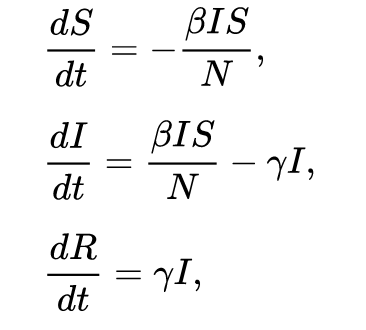

右辺に全体の状態を表す三つの変数 S I Rが出現し、左辺がその微分になっている、微分方程式のセットができあがりました。このように、全体の状態が次にどうなるかを計算する手法を数式としてまとめたものを「モデル」あるいは「力学モデル」といい、変数として確率変数が含まれているものを「確率モデル」といいます。一般にモデルという用語は現実に関する仮定を表し、データベースにおけるモデルはデータベースシステムにおけるデータの構造に関する仮定です。ここでは社会や業務でであう現象に関する数学的な仮定、特に微分方程式として構成されたものをモデルと呼んでいるわけです。

力学は物体の運動を記述した微分方程式のセットです。加速度や速度がどのようにして決まるかを記述した微分方程式を何本かまとめたものが力学です。今我々が見ているのは疫病の力学モデルといえます。

In [0]:
__all__ = ['data', 'beta_0',
           'I_0', 'R_0', 
           'pop_size', 'gamma',
           'confirmed', 'confirmed_sim']

#Parameters
beta_0 = pm.Uniform('beta_0', 1e-9, 1.)
gamma = pm.Uniform('gamma', 1e-9, 1.0)
pop_size = 100000000
# s_frac = pm.Uniform('s_frac', 1e-9, 1.)

#Initial conditions
I_0 = pm.Uniform('I_0', 1., 10.)
S_0 = pop_size - I_0
R_0 = 0.
T_0 = I_0

#SIIRD + vector model for human ectoparasite plague
@pm.deterministic
def SIR(S_0=S_0, I_0=I_0, R_0=R_0, 
         beta_0=beta_0):
    S_h = np.zeros(tinterval)
    I_h = np.zeros(tinterval)
    R_h = np.zeros(tinterval)
    T_h = np.zeros(tinterval)
        
    S_h[0] = S_0
    I_h[0] = I_0
    R_h[0] = R_0
    T_h[0] = T_0
    
    for i in range(1, tinterval):
        N_h = S_h[i-1] + I_h[i-1] + R_h[i-1]
        
        dr = I_h[i-1] * gamma
        ii = (S_h[i-1] / pop_size) * I_h[i-1]*beta_0
        di = ii - dr
        dt = ii
        ds = - ii

        S_h[i] = S_h[i-1] + di
        I_h[i] = I_h[i-1] + di
        R_h[i] = R_h[i-1] + dr
        T_h[i] = I_h[i-1] + dt

    return S_h, I_h, R_h, T_h

D_h = pm.Lambda('D_h', lambda SIR=SIR: SIR[3])

#Likelihood
confirmed = pm.Poisson('confirmed', mu=D_h, value=data, observed=True)
confirmed_sim = pm.Poisson('confirmed_sim', mu=D_h)

モデルは微分方程式から普通の関数に数学を使って変形することができるものもありますが、大部分はそのような解法が無いか、未だ見つかっていません。しかし、微分方程式が揃っていれば、次の状態を計算することはできますから、実際に計算機で計算してみて、現実と合っているかを確認する事は可能です。

近年では機械学習として、高次元の数理構造を高次元のデータに合うように調整する手法が整備されてきています。ここではそれらの手法のうち、マルコフ・チェーン・モテカルロと呼ばれる手法を用いてSIRモデルをデータに合うように調整し、疫病の脅威を見積もってみましょう。

In [0]:
if __name__ == '__main__':
    vars = ['data', 'beta_0',
           'I_0', 'R_0', 
           'pop_size', 'gamma',
           'confirmed', 'confirmed_sim']
    
    mc = pm.MCMC([beta_0, gamma, I_0, confirmed, confirmed_sim])
    mc.use_step_method(pm.AdaptiveMetropolis, [beta_0, gamma, I_0])
    mc.sample(iter=2000, burn=1000, thin=10, verbose=0)
    mc.sample(iter=2000, burn=1000, thin=10, verbose=0)

    mc.db.close()

データと計算資源の限界から、あまりうまくフィッティングできませんでした。

特に、USのデータには全くフィットしません。SIRモデルのIが充分に小さい場合は　S/人口　はほぼ1で定数とみなせますから、diはIの定数倍となります。微分しても同じ関数のままになっているこのIにあてはまるような関数は指数関数です。つまり感染拡大初期は指数関数的に増大することがわかります。感染者が外出すれば未感染者としか出会わないので感染者が増える分だけ増分も増えるのでこうなります。

USのデータはある時期から指数関数ではなくなっています。人間の観測能力には限界があり、それを超えて増え続ける患者を数える事はできない、という事実がデータからわかります。そのようにモデルを構成すればフィットさせる事ができるでしょうが、実際に我々が必要とする数値をそこから計算することは容易ではなさそうです。指数関数部分だけをみると毎日二倍になっていますからそれだけで充分ではないでしょうか。

In [0]:
mc.summary()

In [0]:
%matplotlib inline
plot(mc)

In [0]:
%matplotlib inline
# 推定結果の可視化
plt.figure(figsize=(10,10))
plt.title('corona')
plt.xlabel('Day')
plt.ylabel('confirmed infectious')
plt.plot(data, 'o', mec='black', color='black', label='confirmed infectious')
plt.plot(confirmed_sim.stats()['mean'], color='red', linewidth=1, label='PPP (mean)')
y_min = confirmed_sim.stats()['quantiles'][2.5]
y_max = confirmed_sim.stats()['quantiles'][97.5]
plt.fill_between(range(0,len(data)), y_min, y_max, color='r', alpha=0.3, label='PPP (95% CI)')
plt.legend()

このように、データが生起する仕組みを考え、それにもとづいて解析を行ったり予測をする事で経営や社会に貢献することが、究極的にいえばデータ分析の目的です。その核心を構成しているのは確率として予測不可能な部分を抽象化した数理モデルであり、微分方程式です。微分方程式と言うと難しく感じますが、仕組みは先に見たとおり、じつに初歩的で、計算内容もここで扱ったものは単純であり、エクセルを用いて実装する事も容易です。

諸事情を観察するかぎりでは、日本の感染確率 βは 0.1 から 0.2 回復率γは 0.08 前後のようです。これを使ってSIRモデルを別途作成し、今後どうなるかを計算してみるのもいいかもしれません。あまり楽観的な結果にはならないので、結果を口外しない約束ができ、かつ、蓋をあける勇気のある人だけがやってみてください。

### 片付け

#### GCPプロジェクトの削除

In [0]:
! echo PROJECT_ID = {PROJECT_ID}
! gcloud projects delete {PROJECT_ID}